In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error 
###All the libraries!!!

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Supressing a warning about deprecated sns.distplot further down

In [3]:
data = pd.read_csv('fifa21_male2.csv')
data.shape

C:\Users\chris\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(17125, 107)

In [61]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.head()

,Name,Age,OVA,Nationality,BP,POT,Height,Weight,foot,Value,Wage,Release Clause,Total Stats,Base Stats
0,G. Pasquale,33,69,Italy,LWB,69,72.0,181,Left,790.569415,83.666003,0.000000,1929,408
1,Luis García,37,71,Spain,CM,71,70.0,143,Right,774.596669,83.666003,1048.808848,1906,385
2,J. Cole,33,71,England,CAM,71,69.0,161,Right,1048.808848,122.474487,0.000000,1770,354
3,D. Yorke,36,68,Trinidad &amp; Tobago,ST,82,71.0,165,Right,0.000000,0.000000,0.000000,1348,369
4,D. Odonkor,27,66,Germany,RW,70,68.0,163,Right,851.469318,70.710678,0.000000,1649,360


In [62]:
data.columns


Index(['Name', 'Age', 'OVA', 'Nationality', 'BP', 'POT', 'Height', 'Weight',
       'foot', 'Value', 'Wage', 'Release Clause', 'Total Stats', 'Base Stats'],
      dtype='object')

In [5]:
#dropping all the far right position stats cols and gender col. stats not needed and gender is all male
data = data.drop(data.loc[:, 'LS':'Gender'].columns, axis=1)

#Droppign superfluos identifier col
data = data.drop('ID', axis = 1)

# Dropping Club as not needed and makes too many unique values
data = data.drop('Club', axis = 1)

# Droping A/W and D/W cols because unknown data
data = data.drop(['A/W', 'D/W'], axis = 1)

#Dropping all individual stat columns. Total Stats col rep[resents sum of these
data = data.drop(data.loc[:, 'Attacking':'GK Reflexes'].columns,axis=1 )
data = data.drop(data.loc[:, 'PAC':'Hits'].columns,axis=1)

# Droping cols with irregular characters. Stars in this case
data = data.drop(['W/F', 'SM', 'IR'], axis = 1)

# Dropping image files cols
data = data.drop(['Player Photo', 'Club Logo', 'Flag Photo'], axis = 1)

#loan end dropped due to high na %, position dropped due to null count and redundancy ('BP' is best position, Position is not necessary)
data = data.drop(['Loan Date End', 'Position'], axis = 1)

#dropping contract cols
data = data.drop(['Team & Contract', 'Contract'], axis=1)


In [6]:
data.columns

Index(['Name', 'Age', 'OVA', 'Nationality', 'BOV', 'BP', 'POT', 'Height',
       'Weight', 'foot', 'Growth', 'Value', 'Wage', 'Release Clause',
       'Total Stats', 'Base Stats'],
      dtype='object')

In [7]:
data.head()

,Name,Age,OVA,Nationality,BOV,BP,POT,Height,Weight,foot,Growth,Value,Wage,Release Clause,Total Stats,Base Stats
0,G. Pasquale,33,69,Italy,71,LWB,69,"6'0""",181lbs,Left,0,€625K,€7K,€0,1929,408
1,Luis García,37,71,Spain,70,CM,71,"5'10""",143lbs,Right,0,€600K,€7K,€1.1M,1906,385
2,J. Cole,33,71,England,71,CAM,71,"5'9""",161lbs,Right,0,€1.1M,€15K,€0,1770,354
3,D. Yorke,36,68,Trinidad &amp; Tobago,70,ST,82,"5'11""",165lbs,Right,14,€0,€0,€0,1348,369
4,Iniesta,36,81,Spain,82,CAM,81,"5'7""",150lbs,Right,0,€5.5M,€12K,€7.2M,2014,420


In [8]:
data['Growth'].value_counts()

 0     5741
 1     1002
 3      976
 5      874
 7      836
 9      784
 6      772
 8      733
 10     623
 11     598
 4      587
 2      559
 14     497
 12     481
 13     436
 15     409
 16     298
 17     279
 18     190
 20     186
 19     126
 21      46
 22      40
 23      27
 24      13
 25       8
 26       3
-1        1
Name: Growth, dtype: int64

In [9]:
#Dropping 'Growth' col. Data is unknown, values are mostly 0
data=data.drop('Growth', axis=1)

In [10]:
data['Release Clause'].value_counts()

€0        1785
€1.1M      525
€1.2M      441
€1.3M      421
€1.4M      389
          ... 
€87M         1
€49.5M       1
€70.9M       1
€49.8M       1
€367K        1
Name: Release Clause, Length: 1200, dtype: int64

In [11]:
data.shape

(17125, 15)

In [12]:
#Checking for nulls. Low amounts will be corrected. Very high amounts will be dropped cols
pd.set_option('display.max_rows', None)
data.isna().sum()/len(data)*100 


Name              0.0
Age               0.0
OVA               0.0
Nationality       0.0
BOV               0.0
BP                0.0
POT               0.0
Height            0.0
Weight            0.0
foot              0.0
Value             0.0
Wage              0.0
Release Clause    0.0
Total Stats       0.0
Base Stats        0.0
dtype: float64

In [13]:
## Converting n/a's with mean values by position using groupby. 
# # ie mean Volleys of CM position will fill any n/a volleys of CM players

# #Check groupby results
# data.groupby('BP')['Volleys'].mean()

# #Test method on single col
# data['Volleys'] = data['Volleys'].fillna(data.groupby('BP')['Volleys'].transform('mean'))


# #make a list of the cols to iterate this over
# colswna = ['Volleys', 'Curve', 'Agility', 'Balance', 'Jumping',
#                'Interceptions', 'Positioning', 'Vision', 'Composure', 'Sliding Tackle']
# for col in colswna:
#     data[colswna] = data[colswna].fillna(data.groupby('BP')[colswna].transform('mean'))


###### I ultimately dropped all of these stat columns that this method was devised to fix 
######becuase there were just too many columns in the df to work with further down the line. 
######I was really pleased with this method though so I'm keeping it here

In [14]:
data.isna().sum()/len(data)*100 


Name              0.0
Age               0.0
OVA               0.0
Nationality       0.0
BOV               0.0
BP                0.0
POT               0.0
Height            0.0
Weight            0.0
foot              0.0
Value             0.0
Wage              0.0
Release Clause    0.0
Total Stats       0.0
Base Stats        0.0
dtype: float64

In [15]:
data.head()

,Name,Age,OVA,Nationality,BOV,BP,POT,Height,Weight,foot,Value,Wage,Release Clause,Total Stats,Base Stats
0,G. Pasquale,33,69,Italy,71,LWB,69,"6'0""",181lbs,Left,€625K,€7K,€0,1929,408
1,Luis García,37,71,Spain,70,CM,71,"5'10""",143lbs,Right,€600K,€7K,€1.1M,1906,385
2,J. Cole,33,71,England,71,CAM,71,"5'9""",161lbs,Right,€1.1M,€15K,€0,1770,354
3,D. Yorke,36,68,Trinidad &amp; Tobago,70,ST,82,"5'11""",165lbs,Right,€0,€0,€0,1348,369
4,Iniesta,36,81,Spain,82,CAM,81,"5'7""",150lbs,Right,€5.5M,€12K,€7.2M,2014,420


In [16]:
data.shape

(17125, 15)

In [17]:
#Checking and correcting data types
data.dtypes

Name              object
Age                int64
OVA                int64
Nationality       object
BOV                int64
BP                object
POT                int64
Height            object
Weight            object
foot              object
Value             object
Wage              object
Release Clause    object
Total Stats        int64
Base Stats         int64
dtype: object

In [18]:
# Definign a function to clean and convert Height and Weight columns 
def fix_height(ht):
    
    ht_ = ht.split("'")
    ft_ = float(ht_[0])
    in_ = float(ht_[1].replace('"',''))
    return (12*ft_) + in_

data['Height'] = data['Height'].apply(lambda x:fix_height(x))

In [19]:
data["Height"].dtypes

dtype('float64')

In [20]:
def clean_weight(wt):
    wt_ = wt.replace('lbs','')
    wt_int = int(wt_)
    return wt_int

data['Weight'] = data['Weight'].apply(lambda x:clean_weight(x))

In [21]:
data['Weight'].dtypes

dtype('int64')

In [22]:
# Converting 'Value' 'Wage' and 'Release Clause'

In [23]:
def money_launder(mon):
    clmon = mon[1:]
    if clmon[-1] == 'K':
        clmon = clmon[:-1]
        clmon = float(clmon)
        clmon = clmon*1000
    elif clmon[-1] == 'M':
        clmon = clmon[:-1]
        clmon = float(clmon)
        clmon = clmon*1000000
    return clmon


In [24]:
data['Value'] = data['Value'].apply(lambda x:money_launder(x))
data['Value'] = pd.to_numeric(data['Value'], errors = 'coerce')

In [25]:
data['Value'].dtype

dtype('float64')

In [26]:
data['Wage'] = data['Wage'].apply(lambda x:money_launder(x))
data['Wage'] = pd.to_numeric(data['Wage'], errors = 'coerce')

In [27]:
data['Release Clause'] = data['Release Clause'].apply(lambda x:money_launder(x))
data['Release Clause'] = pd.to_numeric(data['Release Clause'], errors = 'coerce')

In [28]:
# Trying to clean the 'Hits' column. Some values are listed at eg 1.1k instead of 1100. 
# When the function is called receive error "'int' object is not subscriptable" traced back to "if hit[-1]=='K':"
# Check type of data and is type sting "type(data.Hits[0])"  returns "str" so subscripting shoukld work??
### Column was later dropped with other stats above

#data['Hits'].value_counts()

# def clean_hits(hit):
#     if hit[-1]=='K':
#         hit = hit[:-1]
#         hit = hit.split(".")
#         hi = float(hit[0])
#         hi_ = hi*1000
#         ts = float(hit[-1])
#         ts_ = ts*100
#         hit = hi_ + ts_
#         return hit
#     else:
#         return hit


# data['Hits'] = data['Hits'].apply(lambda x:clean_hits(x)) 




In [29]:
data.head()

,Name,Age,OVA,Nationality,BOV,BP,POT,Height,Weight,foot,Value,Wage,Release Clause,Total Stats,Base Stats
0,G. Pasquale,33,69,Italy,71,LWB,69,72.0,181,Left,625000.0,7000.0,0.0,1929,408
1,Luis García,37,71,Spain,70,CM,71,70.0,143,Right,600000.0,7000.0,1100000.0,1906,385
2,J. Cole,33,71,England,71,CAM,71,69.0,161,Right,1100000.0,15000.0,0.0,1770,354
3,D. Yorke,36,68,Trinidad &amp; Tobago,70,ST,82,71.0,165,Right,0.0,0.0,0.0,1348,369
4,Iniesta,36,81,Spain,82,CAM,81,67.0,150,Right,5500000.0,12000.0,7200000.0,2014,420


In [30]:
# Checking column  for incorrect responses ie rihgt, letf, etc.
data['foot'].value_counts()

Right    12906
Left      4219
Name: foot, dtype: int64

In [31]:
## EDA Phase

In [32]:
data.describe()

,Age,OVA,BOV,POT,Height,Weight,Value,Wage,Release Clause,Total Stats,Base Stats
count,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,1.712500e+04,17125.000000,1.712500e+04,17125.000000,17125.000000
mean,25.272934,66.965022,67.900204,72.489810,71.347620,165.658861,2.567377e+06,10532.928467,4.574445e+06,1631.256175,361.372146
std,4.942665,6.864329,6.637538,5.769949,2.711241,15.818185,5.372622e+06,21145.376646,1.033846e+07,260.357024,40.252290
min,16.000000,38.000000,42.000000,47.000000,61.000000,110.000000,0.000000e+00,0.000000,0.000000e+00,731.000000,228.000000
25%,21.000000,62.000000,64.000000,69.000000,69.000000,154.000000,3.750000e+05,1000.000000,5.080000e+05,1492.000000,333.000000
50%,25.000000,67.000000,68.000000,72.000000,71.000000,165.000000,8.000000e+05,3000.000000,1.300000e+06,1659.000000,362.000000
75%,29.000000,72.000000,72.000000,76.000000,73.000000,176.000000,2.400000e+06,11000.000000,3.900000e+06,1812.000000,390.000000
max,53.000000,93.000000,93.000000,95.000000,81.000000,243.000000,1.055000e+08,560000.000000,2.031000e+08,2316.000000,498.000000


In [33]:
cor_matrix = data.corr()
cor_matrix

,Age,OVA,BOV,POT,Height,Weight,Value,Wage,Release Clause,Total Stats,Base Stats
Age,1.000000,0.517099,0.456734,-0.237619,0.092935,0.258682,0.095981,0.200851,0.075386,0.280383,0.414897
OVA,0.517099,1.000000,0.985877,0.592268,0.027077,0.151834,0.631679,0.592925,0.597617,0.607676,0.832618
BOV,0.456734,0.985877,1.000000,0.628323,0.015950,0.132560,0.640818,0.592453,0.608384,0.635037,0.830127
POT,-0.237619,0.592268,0.628323,1.000000,-0.021094,-0.039809,0.563570,0.462235,0.549201,0.329178,0.474763
Height,0.092935,0.027077,0.015950,-0.021094,1.000000,0.766072,-0.000407,0.020740,0.001362,-0.367699,-0.121205
Weight,0.258682,0.151834,0.132560,-0.039809,0.766072,1.000000,0.040257,0.068695,0.034724,-0.246410,0.005923
Value,0.095981,0.631679,0.640818,0.563570,-0.000407,0.040257,1.000000,0.822728,0.979295,0.393043,0.526843
Wage,0.200851,0.592925,0.592453,0.462235,0.020740,0.068695,0.822728,1.000000,0.798432,0.379345,0.479638
Release Clause,0.075386,0.597617,0.608384,0.549201,0.001362,0.034724,0.979295,0.798432,1.000000,0.368406,0.497094
Total Stats,0.280383,0.607676,0.635037,0.329178,-0.367699,-0.246410,0.393043,0.379345,0.368406,1.000000,0.678885


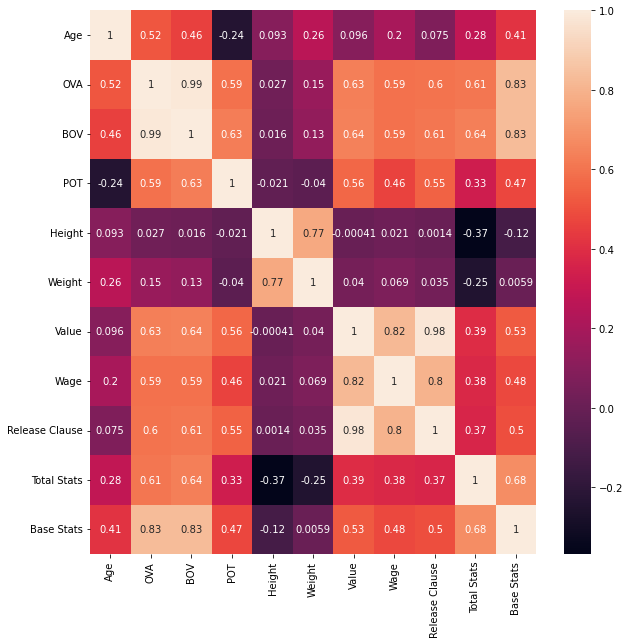

In [34]:
fig, ax = plt.subplots(figsize=(10,10)) 

sns.heatmap(cor_matrix, annot=True)


##OVA and BOV hav .99 collinearity. Will drop BOV

data = data.drop('BOV', axis = 1)

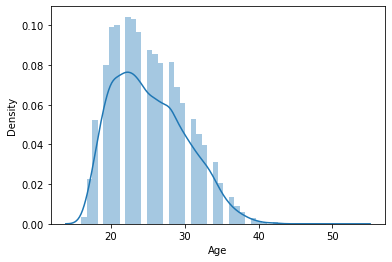

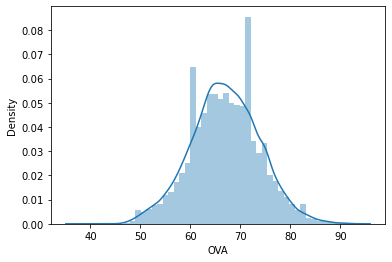

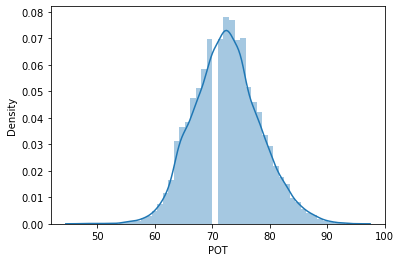

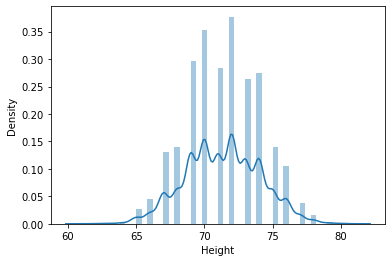

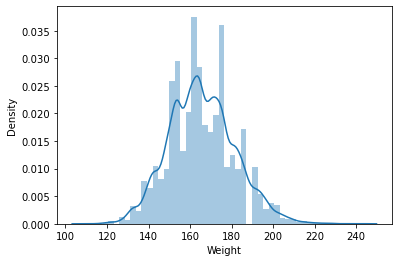

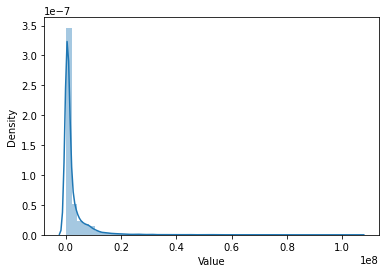

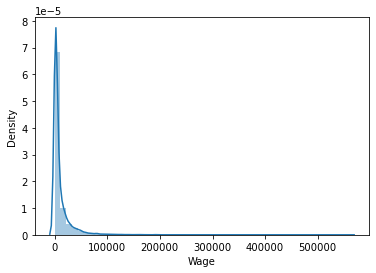

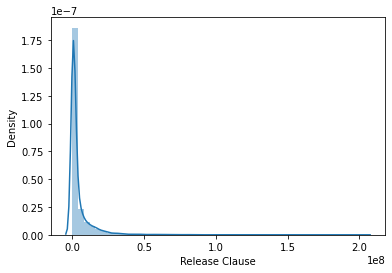

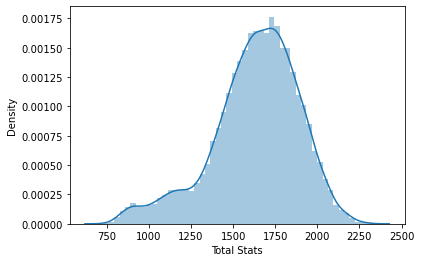

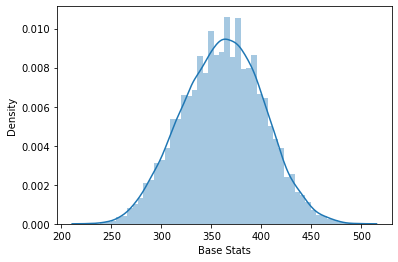

In [35]:
#This will print a distribution chart for all num cols. Columns can be normalized/transformed as needed 


for col in data.select_dtypes('number').columns:
    sns.distplot(data[col])
    plt.show()

<AxesSubplot:xlabel='Height', ylabel='Density'>

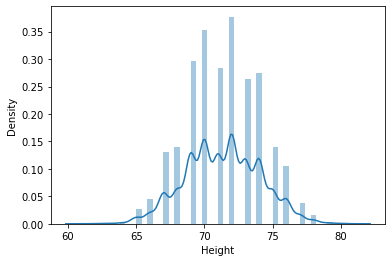

In [36]:
##Calculate interquartile range (25%--75%). Set limit variables based on IQR and filter column on limits
##Standardizing column data distribution and filters outliers
##Finally after running any filter the index must be reset

IQR = np.percentile(data['Height'], 75) - np.percentile(data['Height'], 25)
u_limit = np.percentile(data['Height'], 75) + 3*IQR
l_limit = np.percentile(data['Height'], 25) - 3*IQR
data = data[(data['Height'] < u_limit) & (data['Height'] > l_limit)]
data = data.reset_index(drop=True)
sns.distplot(data['Height'])

<AxesSubplot:xlabel='Weight', ylabel='Density'>

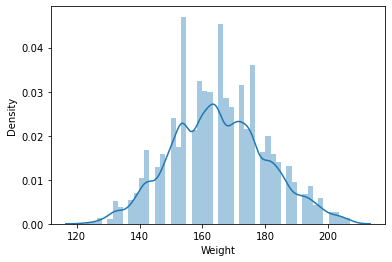

In [37]:
IQR = np.percentile(data['Weight'], 75) - np.percentile(data['Weight'], 25)
u_limit = np.percentile(data['Weight'], 75) + 1.5*IQR
l_limit = np.percentile(data['Weight'], 25) - 1.5*IQR
data = data[(data['Weight'] < u_limit) & (data['Weight'] > l_limit)]
data = data.reset_index(drop=True)
sns.distplot(data['Weight'])

<AxesSubplot:xlabel='Value', ylabel='Density'>

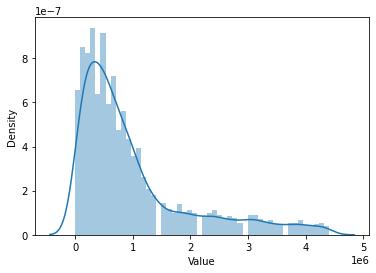

In [38]:
IQR = np.percentile(data['Value'], 75) - np.percentile(data['Value'], 25)
u_limit = np.percentile(data['Value'], 75) + 1*IQR
l_limit = np.percentile(data['Value'], 25) - 1.5*IQR
data = data[(data['Value'] < u_limit) & (data['Value'] > l_limit)]
data = data.reset_index(drop=True)
sns.distplot(data['Value'])

<AxesSubplot:xlabel='Value', ylabel='Density'>

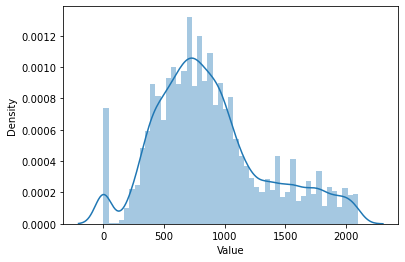

In [39]:
def sq_rt_trans(x):
    if x<0:
        return 0
    else:
        return x**.5

data['Value'] = list(map(sq_rt_trans, data['Value']))
sns.distplot(data['Value'])

<AxesSubplot:xlabel='Wage', ylabel='Density'>

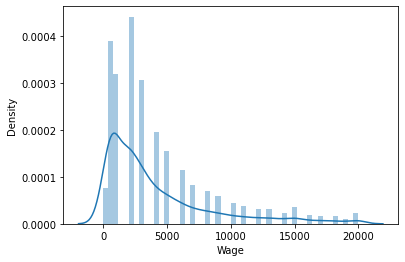

In [40]:
IQR = np.percentile(data['Wage'], 75) - np.percentile(data['Wage'], 25)
u_limit = np.percentile(data['Wage'], 75) + 3*IQR
l_limit = np.percentile(data['Wage'], 25) - 1.5*IQR
data = data[(data['Wage'] < u_limit) & (data['Wage'] > l_limit)]
data = data.reset_index(drop=True)
sns.distplot(data['Wage'])

<AxesSubplot:xlabel='Wage', ylabel='Density'>

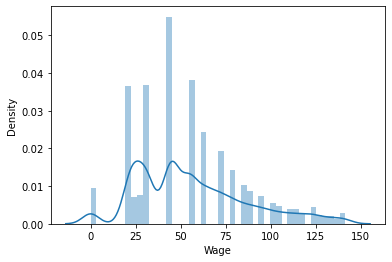

In [41]:
data['Wage'] = list(map(sq_rt_trans, data['Wage']))
sns.distplot(data['Wage'])

<AxesSubplot:xlabel='Release Clause', ylabel='Density'>

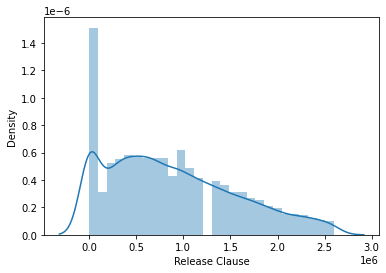

In [42]:
IQR = np.percentile(data['Release Clause'], 75) - np.percentile(data['Release Clause'], 25)
u_limit = np.percentile(data['Release Clause'], 75) + .5*IQR
l_limit = np.percentile(data['Release Clause'], 25) - 1.5*IQR
data = data[(data['Release Clause'] < u_limit) & (data['Release Clause'] > l_limit)]
data = data.reset_index(drop=True)
sns.distplot(data['Release Clause'])

<AxesSubplot:xlabel='Release Clause', ylabel='Density'>

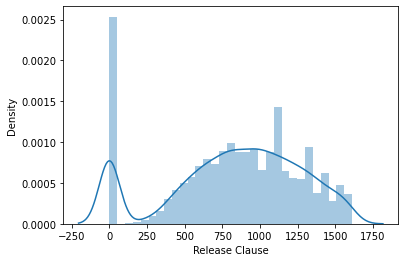

In [43]:
data['Release Clause'] = list(map(sq_rt_trans, data['Release Clause']))
sns.distplot(data['Release Clause'])

<AxesSubplot:xlabel='Total Stats', ylabel='Density'>

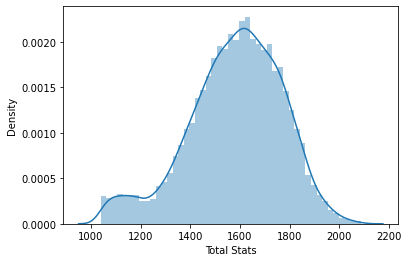

In [44]:
IQR = np.percentile(data['Total Stats'], 75) - np.percentile(data['Total Stats'], 25)
u_limit = np.percentile(data['Total Stats'], 75) + 1.5*IQR
l_limit = np.percentile(data['Total Stats'], 25) - 1.5*IQR
data = data[(data['Total Stats'] < u_limit) & (data['Total Stats'] > l_limit)]
data = data.reset_index(drop=True)
sns.distplot(data['Total Stats'])

In [45]:
#Separating the target data as the variable Y
y = data['OVA']
x = data.drop(['OVA'], axis = 1)

In [46]:
y.shape

(10875,)

In [47]:
x.shape

(10875, 13)

In [48]:
#Encoding "foot" col using OneHot
OHE = OneHotEncoder(drop='first')

Foot_OHE = OHE.fit_transform(x['foot'].values.reshape(-1, 1)).toarray()
Foot_OHE = pd.DataFrame(Foot_OHE)
Foot_OHE.head()



,0
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0


In [49]:
#Encloding the nationality column with Labelencoder

LE = LabelEncoder()

nat = LE.fit_transform(x['Nationality'])
nat = pd.DataFrame(nat)
nat.head()             
                       
                       
                     



,0
0,76
1,136
2,47
3,144
4,57


In [50]:
#Scaliong numerical data columns
scale = MinMaxScaler().fit_transform(x.select_dtypes('number'))
scale = pd.DataFrame(scale)

In [51]:
#Joining encoded columns and scaled num cols into a single feature data dataframe
feature = pd.concat([Foot_OHE, nat, scale], axis=1)
feature.shape

(10875, 11)

In [52]:
#Dividing data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(feature, y, test_size=.2, random_state=100)

In [53]:
# Applying the model to training data
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [54]:
predictions = model.predict(x_test)

In [55]:
predictions[:10]

array([62.38526773, 64.88499122, 63.94288554, 61.67724189, 63.98897812,
       65.40166065, 65.16454675, 65.1475093 , 60.27856871, 62.14586106])

In [56]:
y_test[:10]

7495    65
3695    66
2976    63
8812    63
7085    65
9522    65
6790    65
557     64
1637    62
497     61
Name: OVA, dtype: int64

In [57]:
mse = mean_squared_error(predictions, y_test)
mse

3.4825273841164126

In [58]:
rmse = mse**.5
rmse

1.8661530977163725

In [59]:
mae = mean_absolute_error(predictions, y_test)
mae

1.3930025737180287

In [60]:
r_sq = r2_score(predictions, y_test)
r_sq

0.8397780016844768